In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
import pytorch_lightning as pl
import torch
from scipy.ndimage import gaussian_filter
from sklearn.metrics import mean_squared_error
import os
import pandas as pd
import skimage.measure as measure
import scipy
from skimage.morphology import disk
import torchvision

import torch.nn as nn

import ufl
import dolfin as dlf
import dolfin_adjoint as d_ad
import pyadjoint as pyad

from torchvision import transforms

import warnings
import time
warnings.filterwarnings('ignore')
from tqdm.autonotebook import tqdm  


from utils.nn import ConvNextCell, DownsampleLayer
from utils.PB_utils import Dataset, PB_model
import utils.proc as proc

#from process_mask_generate_mesh

%load_ext autoreload
%autoreload 2
%matplotlib inline

pl.seed_everything(1)
np.random.seed(1)

Global seed set to 1
Global seed set to 1


# Dataset

In [2]:
##### Data args ######
data_root="/project/vitelli/cell_stress/MeshDatasets/imrescale-4_maxcellvol-20/"
train_cells="11_cell_1,"
 
##### Training args ######
n_epochs=101
pde_epochs=101
batch_size=16
 


In [3]:
dataset = Dataset(root=data_root, 
                  cells_to_include=['11_cell_1'], 
                  frames_to_include = np.arange(0,120,3),#[0,39,79,119], # np.arange(2) 
                  n_include=16, indices=16)

print("DF cells:", dataset.df.cell.unique(), "\t DF len:", len(dataset.df))

DF cells: ['11_cell_1'] 	 DF len: 35


In [4]:
##### Model Args ######
N_layers=5
LR=0.00001
PDE_LR=0.001
gamma=0.995

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')


# Seed before making model for reproducibility
torch.manual_seed(0)
np.random.seed(0)

model = PB_model( 
                 kernel_size=9,
                 LR=LR,
                 N_layers=5,
                 N_latent_layers=5,
                 hidden_channels=32,
                 gamma=0.995,
                 regularization=None,
                 batch_size=16,
                 logdir=None)

model.to(device);

In [5]:
### PRETRAIN ## 
sig_init = 1e-1
a_init = 1e-1
d_ad.set_working_tape(d_ad.Tape())


loss_history = []

t0 = time.time()
pbar = tqdm(total=n_epochs)
for i in range(n_epochs):
    for s in range(len(dataset)):
        m = i*len(dataset) + s

        sample = dataset[s]
        sample['zyx'] = sample['zyx'].to(device)
        sample['Y_init'] = sample['Y_init'].to(device)
        sample['mask_bool'] = sample['mask_bool'].to(device)

        loss, y_im, sig_a, alpha = model.pretrain(sample['zyx'], 1e2*sample['Y_init'], sig_init, a_init, mask=sample['mask_bool'])

        if torch.isnan(loss):
            raise ValueError(f"Nans encountered, iter {m}")

        #print(loss)
        loss_history.append(loss.detach().cpu().numpy())
        
    pbar.update(1)

  0%|          | 0/101 [00:00<?, ?it/s]

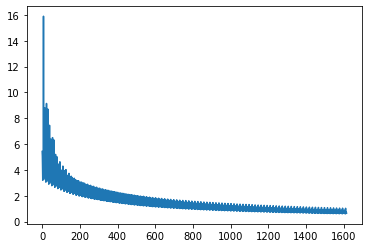

In [8]:
plt.plot(loss_history)

In [ ]:

for g in range(len(model.opt.param_groups)):
    model.opt.param_groups[g]['lr'] = PDE_LR
    
pbar = tqdm(total=n_epochs)
for i in range(n_epochs):
    for s in range(len(dataset)):
        m = i*len(dataset) + s
        sample = dataset[s]
        sample['zyx'] = sample['zyx'].to(torch.device('cpu'))

        constants, y_im, y_mesh_vals, J, _ = model.step(sample['zyx'], sample['Jhat'], len(sample['control_arr']), sample['Y_FctSpace'])

        #model.logger.add_scalar('PDE_Loss', J, global_step=m) 
        #model.logger.add_scalar('PDE_LR', model.opt.param_groups[0]['lr'], global_step=m) 
        pbar.update(1)
    


  0%|          | 0/101 [00:00<?, ?it/s]

In [ ]:
# For plotting F
    mesh = sample['Y_FctSpace'].mesh()
    sigma_a = d_ad.Constant(constants[0].detach().numpy(), name = "sigma")
    alpha = d_ad.Constant(constants[1].detach().numpy(), name = "alpha")

    #### Generate Y, F fields on mesh ####
    Y_mesh = d_ad.Function(sample['Y_FctSpace'])
    F_mesh = proc.vector_img_to_mesh(sample['F'].squeeze().detach().numpy(), dlf.VectorFunctionSpace(mesh, 'CG', 1, dim=2))
    Y_mesh.vector()[:] = y_mesh_vals.detach().numpy()
    u,_,_ = sample['pde_forward'](Y_mesh, sigma_a, alpha, mesh) 

    #model.logger.add_scalar('Sig', constants[0].detach().cpu().numpy(), global_step=i+args.epochs) 
    #model.logger.add_scalar('Alpha', constants[1].detach().cpu().numpy(), global_step=i+args.epochs) 
    #model.plot_Y(i+args.epochs, sample['zyx'].detach().cpu().numpy().squeeze(), y_im.detach().cpu().numpy().squeeze()) 
    #model.plot_F(i+args.epochs, F_mesh, Y_mesh, u) 

    #torch.save(model.state_dict(), os.path.join(args.logdir, './model.pt'))

# Evaluate LR effect on pretraining

In [89]:
loss_all = []

gpu_train = True

pbar_LRs = tqdm(total=6, desc='')
for LR in [1e-3]:
    for N_layers in [10]:
        pbar_LRs.set_description(f'LR {LR:0.2e} N_layers {N_layers}')
        torch.manual_seed(0)
        np.random.seed(0)

        model = PDEModel2D( 
                         kernel_size=15,
                         LR=LR,
                         N_layers=N_layers,
                         N_latent_layers=N_layers,
                         hidden_channels=32,
                         gamma=0.995,
                         regularization=None,
                         batch_size=len(dataset.red_dataset),
                         exp=False)
        
        if gpu_train: model.to(torch.device('cuda:0'))
        

        sig_init = 1e-1
        a_init = 1e-1
        d_ad.set_working_tape(d_ad.Tape())
        #d_ad.get_working_tape().get_blocks()[:] = []
        print(len(d_ad.get_working_tape().get_blocks()))

        pretrain_loss = []
        t0 = time.time()
        epochs = 301
        pbar_outer = tqdm(total=epochs, desc='')
        pbar_inner = tqdm(total=len(dataset), desc='')
        for i in range(epochs):
            pbar_outer.update(1) # update progress bar for each iteration step
            pbar_inner.reset()
            for s in range(len(dataset)):
                pbar_inner.set_description(f'Sample {s}')
                pbar_inner.update(1) # update progress bar for each iteration step
                m = i*len(dataset) + s

                sample = dataset[s]
                
                if gpu_train: sample['zyx'] = sample['zyx'].to(torch.device('cuda:0'))
                if gpu_train: sample['Y_init'] = sample['Y_init'].to(torch.device('cuda:0'))
                if gpu_train: sample['mask_bool'] = sample['mask_bool'].to(torch.device('cuda:0'))


                pretrain_loss.append( [x.detach().cpu().numpy() for x in model.pretrain(sample['zyx'], 1e2*sample['Y_init'], 
                                                                                  sig_init, a_init, mask=sample['mask_bool'])][0])
                if np.any(np.isnan(pretrain_loss)):
                    raise ValueError(f"Nans encountered, iter {m}\t{pretrain_loss[-1]}")
            pbar_outer.set_description(f'Epoch {i}, loss {pretrain_loss[-1]:0.2e}')

        loss_all.append({'N_layers': N_layers, 'LR': LR, 'loss': pretrain_loss})
        pbar_LRs.update(1)


  0%|          | 0/6 [00:00<?, ?it/s]

0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [90]:
y_im = model.forward(sample['zyx'], None)[0].detach().cpu().numpy().squeeze()

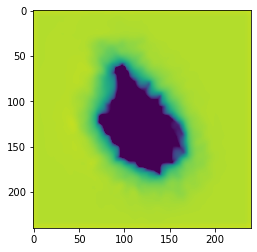

In [94]:
plt.imshow(np.log(y_im), vmax=1e-3, vmin=-20)

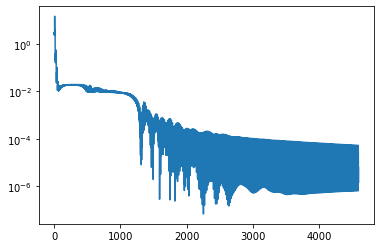

In [51]:
plt.semilogy(pretrain_loss)

dict_keys([0.001])


Text(0.5, 0, 'Epoch')

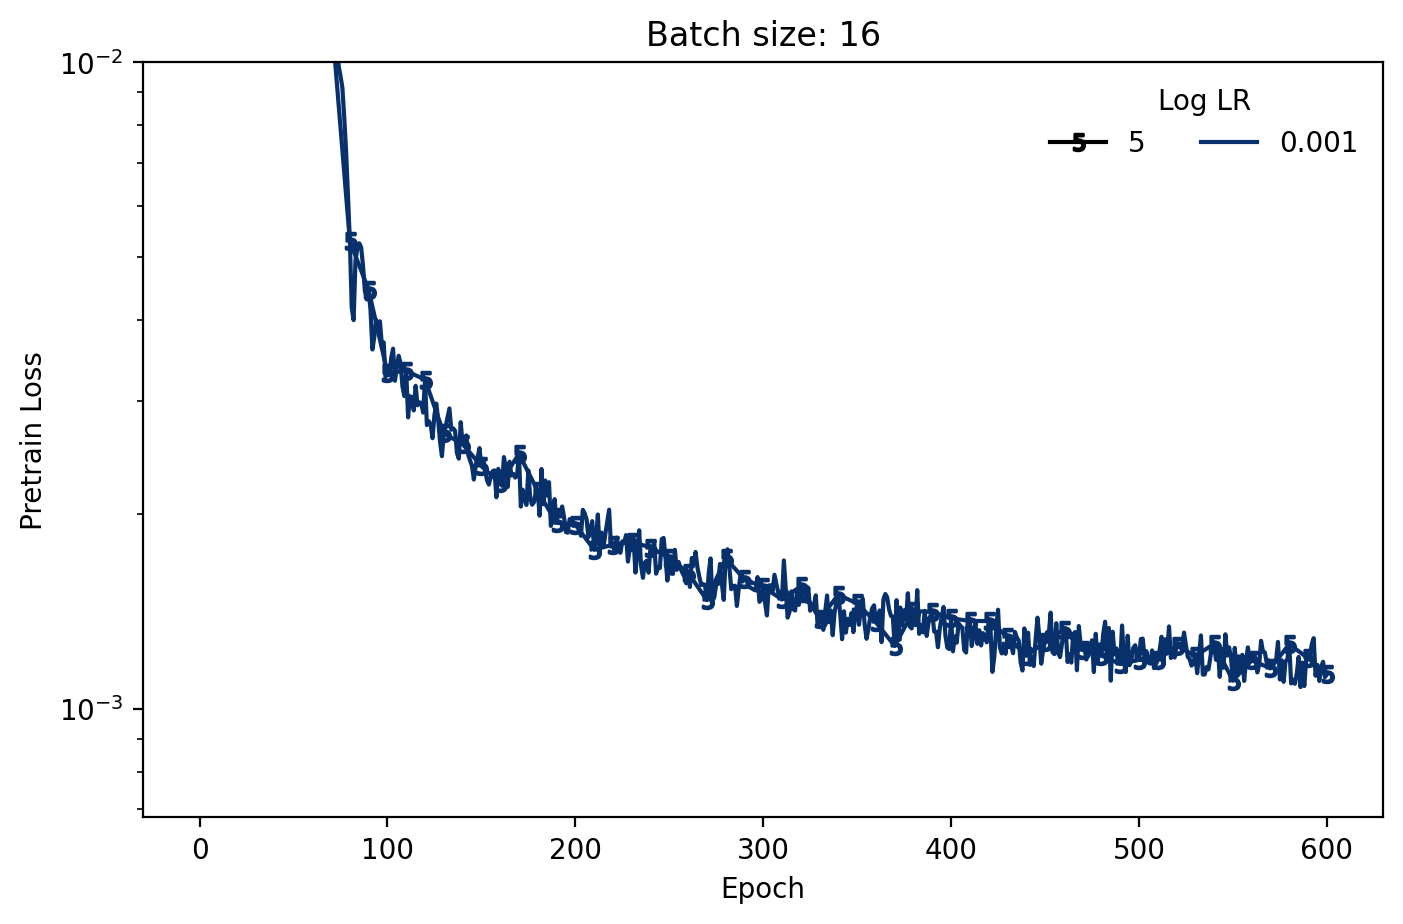

In [45]:
fig,ax=plt.subplots(1,1,figsize=(8,5),dpi=200)

nlayers_list = np.unique([x['N_layers'] for x in loss_all])
loglr = np.unique([x['LR'] for x in loss_all])

markers = {item: f'${item}$' for item in nlayers_list}
colors = {l: np.log10(l)/np.min(np.log10(loglr)) for l in loglr}


print(colors.keys())
freq = 10
ax.set_title(f'Batch size: {model.batch_size}')
for loss_ in loss_all:
    L = loss_['loss']
    clr = colors[loss_['LR']]
    mrkr = markers[loss_['N_layers']]
    L_avg = np.mean( np.asarray(L).reshape(-1, model.batch_size), axis=1)
    #ax.semilogy(np.arange(len(L))/model.batch_size, L, color=plt.get_cmap('Blues')( lr/np.min(loglr) ), label=lr )
    ax.semilogy(L_avg, color=plt.get_cmap('Blues')(clr))
    ax.semilogy(np.arange(len(L_avg))[::freq], L_avg[::freq], color=plt.get_cmap('Blues')(clr), marker=mrkr)
    
    
for m in markers:
    ax.plot([],[],color='k', marker=markers[m], label=m)

    
for c in colors:
    ax.plot([],[],color=plt.get_cmap('Blues')(colors[c]), label=c)
    

ax.legend(title='Log LR', frameon=False, ncol=2)
ax.set_ylim(None, 1e-2)
#ax.set_xlim(150, None)
ax.set_ylabel("Pretrain Loss")
ax.set_xlabel("Epoch")

# Model

In [67]:
for i in range(len(model.opt.param_groups)):
    print(i, model.opt.param_groups[i]['name'])

0 kernels
1 coefs
2 const_net
3 convNext


In [6]:
model = PDEModel2D( 
             kernel_size=15,
             LR=1e-3,
             N_layers=10,
             N_latent_layers=10,
             hidden_channels=32,
             gamma=0.995,
             regularization=None,
             batch_size=len(dataset.red_dataset),
             exp=False)


In [7]:
#print(model.opt)
#print(len(model.opt))
#torch.save(model.state_dict(), './cell_1_model_state_dict.pt')

model.load_state_dict(torch.load('./cell_1_model_state_dict.pt'))


<All keys matched successfully>

In [96]:
state_dict_saved = model.state_dict().copy()

# LR effect on PDE training

In [99]:
pde_loss_all = []

pbar_LRs = tqdm(total=2, desc='')
for LR in [1e-3]:#, 1e-5, 1e-8]:
    for N_layers in [10]:
        pbar_LRs.set_description(f'LR {LR:0.2e} N_layers {N_layers}')
        torch.manual_seed(0)
        np.random.seed(0)

        model = PDEModel2D( 
                         kernel_size=15,
                         LR=LR,
                         N_layers=N_layers,
                         N_latent_layers=N_layers,
                         hidden_channels=32,
                         gamma=0.995,
                         regularization=None,
                         batch_size=len(dataset.red_dataset),
                         exp=False)

        model.load_state_dict(state_dict_saved)

        model.opt.param_groups[0]['lr'] = LR
        model.opt.param_groups[1]['lr'] = LR # coefs
        model.opt.param_groups[2]['lr'] = LR # const_net 

        loss = []

        t0 = time.time()

        pde_epochs = 101
        pde_pbar_outer = tqdm(total=pde_epochs, desc='')
        pde_pbar_inner = tqdm(total=len(dataset), desc='')

        for i in range(pde_epochs):
            pde_pbar_outer.set_description(f'Epoch {i}')
            pde_pbar_outer.update(1) # update progress bar for each iteration step
            pde_pbar_inner.reset()
            for s in range(len(dataset)):
                m = i*len(dataset) + s
                sample = dataset[s]
                
                sample['zyx'] = sample['zyx'].to(torch.device('cpu'))
                sample['Y_init'] = sample['Y_init'].to(torch.device('cpu'))
                sample['mask_bool'] = sample['mask_bool'].to(torch.device('cpu'))


                _, _, _, J, _ = model.step(sample['zyx'], sample['Jhat'], len(sample['control_arr']), sample['Y_FctSpace'])

                loss.append(J)

                pde_pbar_inner.set_description(f'Sample {s}, Loss {J:0.2f}')
                pde_pbar_inner.update(1) # update progress bar for each iteration step

        pde_loss_all.append({'kernel LR': kernel_LR, 'LR': LR, 'loss': loss})


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

NameError: name 'kernel_LR' is not defined

No handles with labels found to put in legend.


dict_keys([])


Text(0.5, 0, 'Epoch')

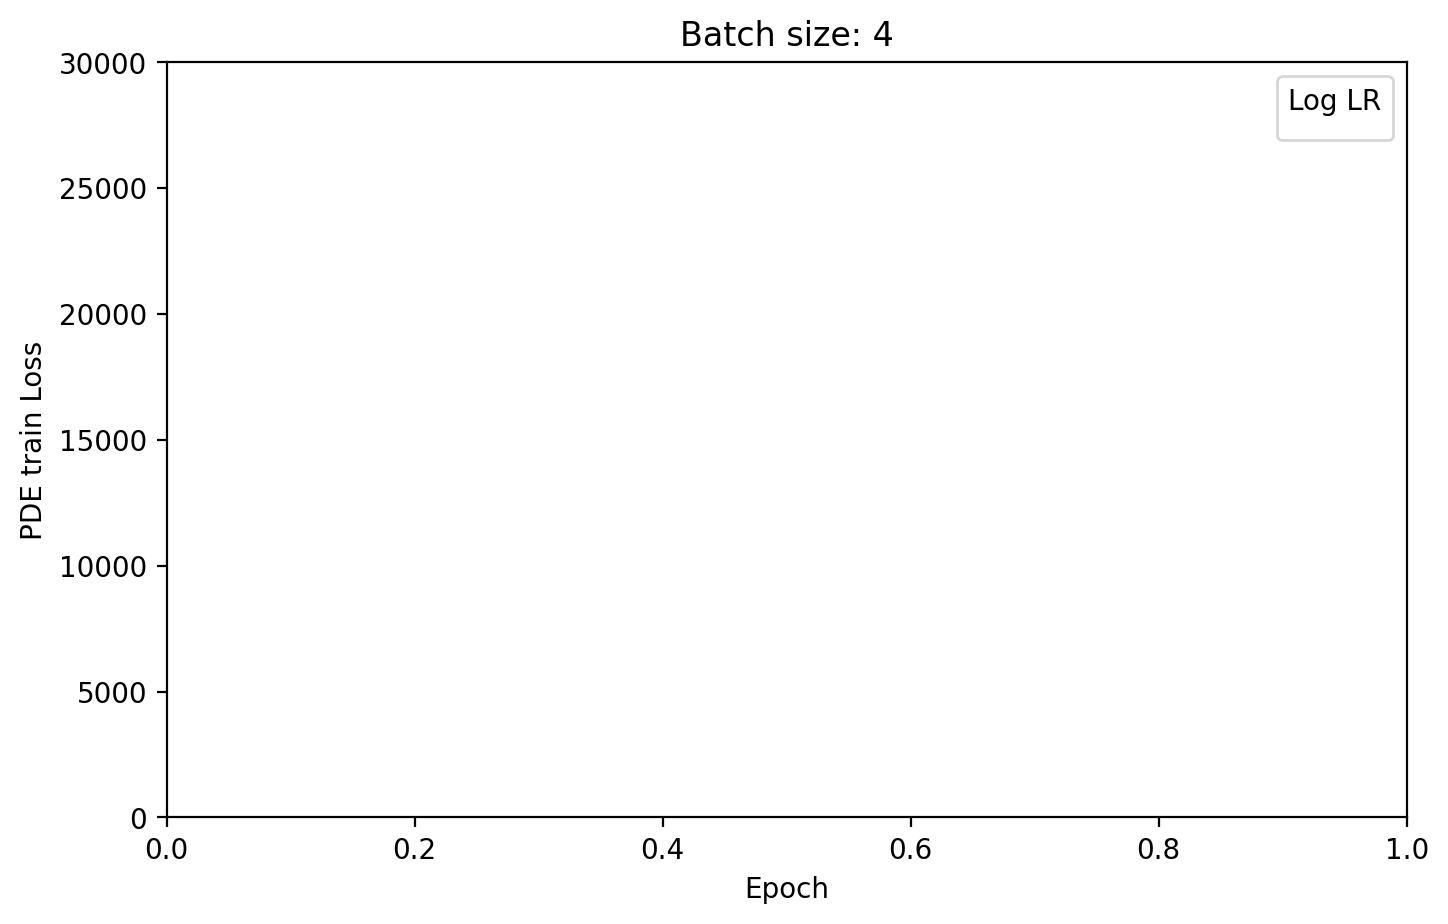

In [45]:
fig,ax=plt.subplots(1,1,figsize=(8,5),dpi=200)

logkernellr = np.unique([x['kernel LR'] for x in pde_loss_all])
loglr = np.unique([x['LR'] for x in pde_loss_all])

markers = {k: item for k, item in zip(logkernellr, np.arange(4,7))}
colors = {l: np.log10(l)/np.min(np.log10(loglr)) for l in loglr}

print(colors.keys())
freq = 1
ax.set_title(f'Batch size: {model.batch_size}')
for loss_ in pde_loss_all:
    L = loss_['loss']
    clr = colors[loss_['LR']]
    mrkr = markers[loss_['kernel LR']]
    L_avg = np.mean( np.asarray(L).reshape(-1, model.batch_size), axis=1)
    ax.semilogy(np.arange(len(L))/model.batch_size, L )#, color=plt.get_cmap('Blues')( lr/np.min(loglr) ), label=lr )
    ax.semilogy(L_avg, color=plt.get_cmap('Blues')(clr))
    ax.semilogy(np.arange(len(L_avg))[::freq], L_avg[::freq], color=plt.get_cmap('Blues')(clr), marker=mrkr, ls='none')
    
    
for m in markers:
    ax.plot([],[],color='k', marker=markers[m], label=m)
for c in colors:
    ax.plot([],[],color=plt.get_cmap('Blues')(colors[c]), label=c)
    

ax.legend(title='Log LR', frameon=True, ncol=2)
ax.set_ylim(None, 3e4)
#ax.set_xlim(150, None)
ax.set_ylabel("PDE train Loss")
ax.set_xlabel("Epoch")

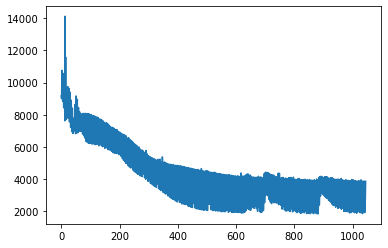

In [46]:
plt.plot(loss)

# Plot

tensor(3.2188e-07)
tensor(0.0023)


NameError: name 'cb_pre' is not defined

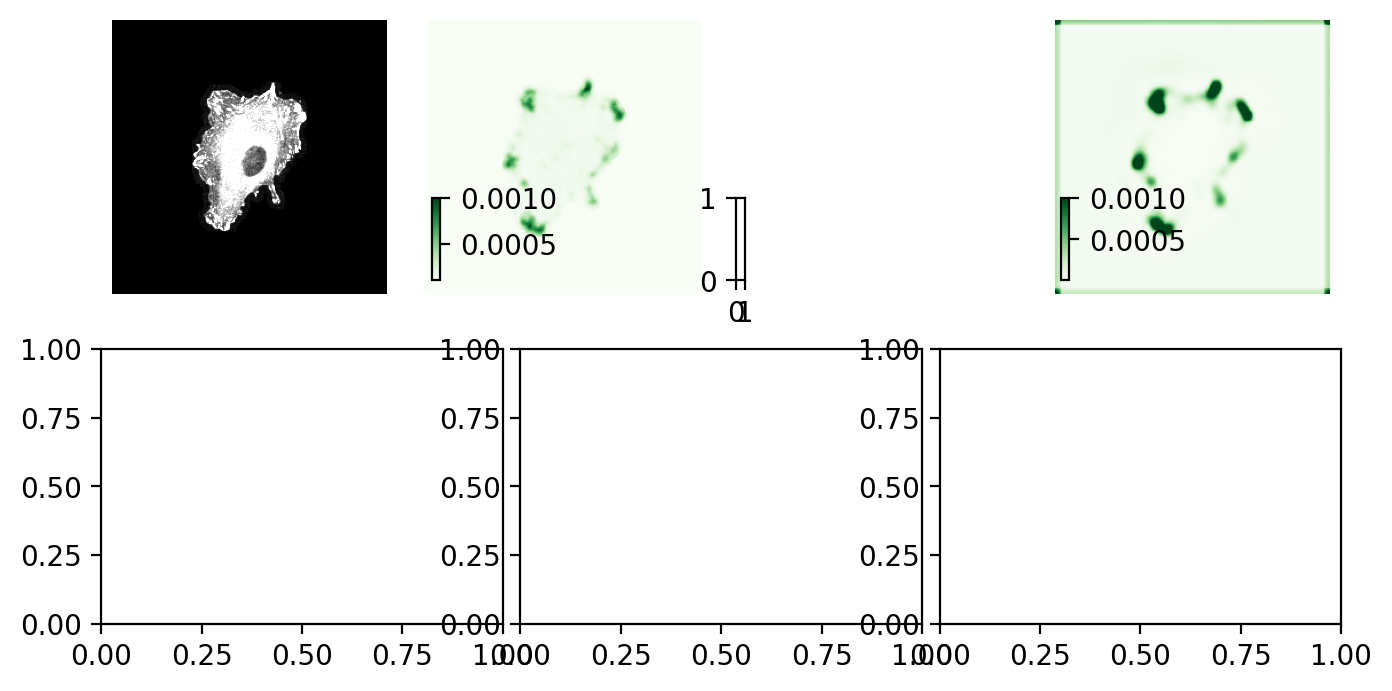

In [100]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8,4),dpi=200)

gs = GridSpec(2, 12, figure=fig)
ax = {}
ax['zyx'] = fig.add_subplot(gs[0, 0:3])
ax['yinit'] = fig.add_subplot(gs[0, 3:6])

ax['ypre'] = fig.add_subplot(gs[0, 6:9])
ax['yfinal'] = fig.add_subplot(gs[0, 9:])
ax['pre_loss'] = fig.add_subplot(gs[1, 0:4])
ax['pde_loss'] = fig.add_subplot(gs[1, 4:8])
ax['consts'] = fig.add_subplot(gs[1, 8:])

for key in ['zyx','yinit','ypre','yfinal']:
    ax[key].axis('off')

sample = dataset[1]
with torch.no_grad():
    y_im, _, _ = model.forward(sample['zyx'],None)

ax['zyx'].imshow(sample['zyx'].squeeze().detach().cpu().numpy(), cmap='gray', origin='lower', vmin=0, vmax=1)

vmax = 1e-3#1e-4#None #Y_init_scale
vmin= None
im_init = ax['yinit'].imshow(sample['Y_init'].squeeze().detach().cpu().numpy(), cmap='Greens', origin='lower', vmin=vmin, vmax=vmax)
#im_pre = ax['ypre'].imshow(y_ims[0].squeeze().detach().numpy(), cmap='Greens', origin='lower', vmin=vmin, vmax=vmax)
#y_post_plot = y_ims[-1].squeeze().detach().numpy()
y_post_plot = y_im.squeeze().detach().cpu().numpy()
print(y_im.min())
print(y_im.max())
#y_post_plot[sample['mask_bool'].squeeze().detach().numpy()==0] = 0
im_post = ax['yfinal'].imshow(y_post_plot, cmap='Greens', origin='lower', vmin=vmin, vmax=vmax)#, vmin=0., vmax=0.00115)

cax_init = ax['yinit'].inset_axes([0.02, 0.05, 0.03, 0.3])
cax_pre = ax['ypre'].inset_axes([0.02, 0.05, 0.03, 0.3])
cax_final = ax['yfinal'].inset_axes([0.02, 0.05, 0.03, 0.3])


cb_init = fig.colorbar(im_init, cax_init)
#cb_pre = fig.colorbar(im_pre, cax_pre)
cb_final = fig.colorbar(im_post, cax_final)

#cb_init.ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useOffset=True)
for cb in [cb_init, cb_pre, cb_final]:
    cb.formatter.set_powerlimits((0, 0))
    cb.ax.yaxis.set_offset_position('left')
    cb.ax.yaxis.offsetText.set_fontsize(8)
    #cb.ax.yaxis.offsetText.set_text('$10^{-3}$')
    #useMathText
    

ax['pre_loss'].semilogy(np.asarray(pretrain_loss)[:,0])
ax['pde_loss'].semilogy(loss)
ax['consts'].plot(constant_evol[:,0], label='$\\sigma_a$', color='b')
ax2 = ax['consts'].twinx()
ax['consts'].plot([],[], label='$\\alpha$', color='gray')
ax2.plot(constant_evol[:,1], label='$\\alpha$', color='gray')

ax['consts'].legend(frameon=False, loc='lower right')
ax['consts'].tick_params(colors='blue', which='both', axis='y')  # 'both' refers to minor and major axes
ax2.tick_params(colors='gray', which='both', axis='y')  # 'both' refers to minor and major axes



for key in ['pre_loss','pde_loss','consts']:
    ax[key].tick_params(axis='both', which='both', direction='in')

#ax['pde_loss'].set_yticklabels([])
#ax['pde_loss'].set_ylim(None, 1e4)
ax['zyx'].set_title('Zyxin')
ax['yinit'].set_title('$Y_{init}$ ($\\propto |F|$)')
ax['ypre'].set_title('$Y$ after \npretraining')
ax['yfinal'].set_title('$Y$ after\nPDE training')
ax['pde_loss'].set_title('PDE training loss')
ax['consts'].set_title('Constants')

fig.set_facecolor('w')

In [80]:
print(np.sum(sample['Y_init'].squeeze().detach().cpu().numpy()**2))
print(np.mean(1e5*sample['Y_init'].squeeze().detach().cpu().numpy()**2))

0.0010698653
0.0018574053


In [60]:
print(dataset[0]['Jhat'].compute_adjoint(

In [50]:
print(np.asarray([x.detach().numpy() for x in y_ims]).shape)

(3, 240, 240)


# Plot forces

In [9]:

def tricolor(f, mesh):
    import matplotlib.tri as tri 
    xy = mesh.coordinates()

    f = dlf.project(f, mesh=mesh)

    pltmesh = f.function_space().mesh()

    f = f._cpp_object
    C = f.compute_vertex_values(pltmesh)#.get_local()
    
    triang = tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())
    
    return triang, C

def triquiver(f, mesh):    
    f = dlf.project(f, mesh=mesh)

    w0 = f.compute_vertex_values(mesh)
    nv = mesh.num_vertices()
    X = mesh.coordinates()
    X = [X[:, i] for i in range(2)]
    U = [w0[i * nv: (i + 1) * nv] for i in range(2)]
    
    return X,U


In [43]:
print(idx)

[88]


In [57]:
frames = cell_1_dataset.df.frame.values
print(frames)
print(np.sort(frames))

[0 1 10 100 101 102 103 104 106 107 108 109 11 110 111 112 113 114 115 116
 117 118 119 12 13 14 15 16 17 18 19 2 20 21 22 23 25 26 27 29 3 30 31 32
 33 34 35 36 37 38 39 4 40 41 42 43 44 45 46 47 48 49 5 50 51 52 53 54 55
 56 57 58 59 6 60 61 62 63 64 65 66 67 68 69 7 70 71 72 73 74 75 76 77 78
 79 8 81 83 85 86 87 88 89 9 90 92 98 99]
[0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25 26 27 29
 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77
 78 79 81 83 85 86 87 88 89 90 92 98 99 100 101 102 103 104 106 107 108
 109 110 111 112 113 114 115 116 117 118 119]


In [59]:

t0 = time.time()
#for frame in cell_1_dataset.df.frame.values:
for i in range(len(cell_1_dataset)):
    sample = cell_1_dataset[i]
    frame = sample['frame']

    mesh = sample['Y_FctSpace'].mesh()

    y_im, y_mesh_vals, const = model.forward(sample['zyx'], sample['Y_FctSpace'])

    sigma_a = d_ad.Constant(const[0].detach().numpy(), name = "sigma")
    alpha = d_ad.Constant(const[1].detach().numpy(), name = "alpha")

    #### Generate Y, F fields on mesh ####
    Y_mesh = d_ad.Function(sample['Y_FctSpace'])
    F_mesh = proc.vector_img_to_mesh(sample['F'].squeeze().detach().numpy(), dlf.VectorFunctionSpace(mesh, 'CG', 1, dim=2))

    #y_mesh_vals[y_mesh_vals<0] = 0

    Y_mesh.vector()[:] = y_mesh_vals.detach().numpy()

    u,_,_ = sample['pde_forward'](Y_mesh, sigma_a, alpha, mesh)   


    ## Plot ##


    fig,ax=plt.subplots(2,3,figsize=(9,6),dpi=200)

    mask = sample['mask_bool'].squeeze()
    #mesh = sample['Y_FctSpace'].mesh()

    for a in ax.T[1:].flat:
        a.imshow(np.zeros_like(mask), cmap='inferno', origin='lower', alpha=0.8)

    ax[1][0].imshow(np.zeros_like(mask), cmap='Greens', origin='lower', alpha=0.8)

    vmax = 3
    for a in ax.T[1:].T:
        im_ex = a[0].tripcolor(*tricolor(ufl.sqrt(ufl.dot(F_mesh,F_mesh)), mesh), vmin=0,vmax=vmax, cmap='inferno')
        im_pr = a[1].tripcolor(*tricolor(ufl.sqrt(ufl.dot(u*Y_mesh,u*Y_mesh)), mesh), vmin=0,vmax=vmax, cmap='inferno')

    for a in ax.flat: a.axis('off')

    arrow_width = 0.005
    dns = 2
    thresh=0.3
    X,U=triquiver( F_mesh, mesh)
    X = np.asarray([x[::dns] for x in X]).T
    U = np.asarray([x[::dns] for x in U]).T

    X = np.asarray([x for u,x in zip(U,X) if np.linalg.norm(u, axis=0)>thresh]).T
    U = np.asarray([u for u in U if np.linalg.norm(u, axis=0)>thresh]).T
    ax[1][1].quiver(*X, *U, color='w', width=arrow_width, scale=10*vmax, alpha=0.8)


    arrow_width = 0.003
    dns = 2
    X,U=triquiver( Y_mesh*u, mesh)
    X = np.asarray([x[::dns] for x in X]).T
    U = np.asarray([x[::dns] for x in U]).T

    X = np.asarray([x for u,x in zip(U,X) if np.linalg.norm(u, axis=0)>thresh]).T
    U = np.asarray([u for u in U if np.linalg.norm(u, axis=0)>thresh]).T
    ax[1][2].quiver(*X, *U, color='w', width=arrow_width, scale=10*vmax, alpha=0.8)


    ax[0][0].set_title('Zyxin')
    ax[1][0].set_title('$Y(x)$')
    ax[0][1].set_title('Target $|\\vec{F}|$')
    ax[0][2].set_title('Predicted $|\\vec{F}|$')
    ax[1][1].set_title('Target $\\vec{F}$')
    ax[1][2].set_title('Predicted $\\vec{F}$')

    ax[0][0].imshow(sample['zyx'].squeeze()/sample['zyx'].max(), cmap='gray', origin='lower', vmin=0, vmax=0.1)
    imy = ax[1][0].tripcolor(*tricolor(ufl.sqrt(ufl.dot(Y_mesh,Y_mesh)), mesh), vmin=0,vmax=2e-3, cmap='Greens')


    ### Colorbars

    imy_cax = ax[1][0].inset_axes([0.05,0.05,0.03,0.15])
    cb_y = fig.colorbar(imy, cax=imy_cax)


    imF_cax = ax[1][1].inset_axes([0.05,0.05,0.03,0.15])
    cb_F = fig.colorbar(im_ex, cax=imF_cax, ticks=[0,3])

    cb_F.ax.yaxis.set_tick_params(color='w')
    cb_F.outline.set_edgecolor('w')
    plt.setp(plt.getp(imF_cax, 'yticklabels'), color='w')
    #plt.setp(plt.getp(imF_cax, 'yticklabels'), text=[0,0])
    imF_cax.set_yticklabels([0, '3 kPa'])

    #cbar.ax.set_ylabel('F')
    plt.setp(plt.getp(imF_cax, 'ylabel'), text='F')
    plt.setp(plt.getp(imF_cax, 'ylabel'), color='w')

    for a in ax.flat:
        a.set_xlim(50,190)
        a.set_ylim(50,190)
        
    fig.savefig(f'./cell_1_prediction_pngs/frame_{frame}.png', format='png', bbox_inches='tight', facecolor='w')
    plt.close('all')
    
    print(f'Done w/ frame {frame}. Time:\t{time.time()-t0:0.2f}')

Done w/ frame 7. Time:	0.92
Done w/ frame 108. Time:	1.82
Done w/ frame 61. Time:	2.70
Done w/ frame 10. Time:	3.60
Done w/ frame 13. Time:	7.02
Done w/ frame 87. Time:	7.94
Done w/ frame 99. Time:	8.85
Done w/ frame 104. Time:	9.76
Done w/ frame 113. Time:	10.67
Done w/ frame 71. Time:	11.58
Done w/ frame 55. Time:	12.49
Done w/ frame 119. Time:	13.71
Done w/ frame 34. Time:	14.63
Done w/ frame 48. Time:	15.53
Done w/ frame 62. Time:	16.45
Done w/ frame 40. Time:	17.35
Done w/ frame 110. Time:	18.26
Done w/ frame 6. Time:	19.13
Done w/ frame 70. Time:	20.03
Done w/ frame 42. Time:	21.30
Done w/ frame 9. Time:	22.20
Done w/ frame 106. Time:	23.09
Done w/ frame 15. Time:	24.01
Done w/ frame 78. Time:	24.90
Done w/ frame 21. Time:	25.81
Done w/ frame 100. Time:	26.72
Done w/ frame 53. Time:	27.61
Done w/ frame 37. Time:	28.50
Done w/ frame 19. Time:	29.88
Done w/ frame 103. Time:	30.78
Done w/ frame 64. Time:	31.66
Done w/ frame 74. Time:	32.56
Done w/ frame 75. Time:	33.45
Done w/ frame

In [27]:
data_root="/project/vitelli/cell_stress/MeshDatasets/imrescale-4_maxcellvol-20/"

np.random.seed(0)
torch.manual_seed(0)


cell_1_dataset = Dataset(root=data_root, 
                  use_F_NN_or_Exp='exp', 
                  cells_to_include=['11_cell_1'], 
                  frames_to_include = np.arange(0,120),#[0,39,79,119], # np.arange(2) 
                  n_include=120, indices=120)

print(len(cell_1_dataset.red_dataset))
print(len(cell_1_dataset))

108
108


In [28]:
F_pred = []
F_exp = []
frames = []
sigmas=[]
alphas=[]

model.eval()

for i in range(len(cell_1_dataset)):
    sample = cell_1_dataset[i]
    mesh = sample['Y_FctSpace'].mesh()
    frame = sample['frame']

    y_im, y_mesh_vals, const = model.forward(sample['zyx'], sample['Y_FctSpace'])

    sigma_a = d_ad.Constant(const[0].detach().numpy(), name = "sigma")
    alpha = d_ad.Constant(const[1].detach().numpy(), name = "alpha")

    #### Generate Y, F fields on mesh ####
    Y_mesh = d_ad.Function(sample['Y_FctSpace'])
    F_mesh = proc.vector_img_to_mesh(sample['F'].squeeze().detach().numpy(), dlf.VectorFunctionSpace(mesh, 'CG', 1, dim=2))

    #y_mesh_vals[y_mesh_vals<0] = 0

    Y_mesh.vector()[:] = y_mesh_vals.detach().numpy()

    u,_,_ = sample['pde_forward'](Y_mesh, sigma_a, alpha, mesh)   

    F_pred.append( dlf.assemble(ufl.sqrt(ufl.dot(u*Y_mesh,u*Y_mesh))*ufl.dx) )
    F_exp.append( dlf.assemble(ufl.sqrt(ufl.dot(F_mesh, F_mesh))*ufl.dx) )
    frames.append(frame)
    sigmas.append(const[0].detach().numpy())
    alphas.append(const[1].detach().numpy())

F_pred = np.asarray(F_pred)
F_exp = np.asarray(F_exp)
frames = np.asarray(frames)
sigmas= np.asarray(sigmas)
alphas=np.asarray(alphas)
